In [3]:
# J'utilise findspark pour le chemin de pyspark et donc rajouter pyspark au sys.path
import findspark
findspark.init()

In [4]:
import os
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
plt.style.use('fivethirtyeight')
# for connections to S3 AWS
import boto3
# pyspark modules
import pyspark 
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, split
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml.feature import PCA
# tnesorflow modules
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

## Lancement de la session Spark

- Configuration des variables d'environnement pour pyspark pour assurer le bon fonctionnement de spark, java, S3, etc.

In [5]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.3 pyspark-shell --conf spark.driver.extraJavaOptions="-Dio.netty.tryReflectionSetAccessible=true",spark.hadoop.fs.s3a.endpoint=s3.eu-west-1.amazonaws.com'

- Lancement d'une Spark Session/Context  (Créer le point d'entrée pour Spark)

In [6]:
sc = SparkContext()
spark = SparkSession.builder.master('local[*]').getOrCreate()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [7]:
# configuration de Pyspark
#s_cf = SparkConf()
#s_cf.set("spark.executor.memory", '4g') # 4GB de RAM pour l'exécuteur
#s_cf.set('spark.executor.cores', '2') # 2 coeurs
#s_cf.set('spark.cores.max', '2') # 2 coeurs max
#s_cf.set("spark.driver.memory",'4g') # 4GB de RAM pour le driver

## Importer les données dans un Spark DataFrame

- Importer données à partir du Bucket (Compartiment) ```S3```  (j'ai déposé mes images sur le service de stockage S3 de mon compte AWS)

In [8]:
s3_url = "s3a://p8-fruits-s3/input_images/*"

image_df = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(s3_url)
image_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



Utiliser withColumn pour rajouter une colonne Label afin d'étiqueter chaque image

In [9]:
image_df = image_df.withColumn('label', split(col('path'), '/').getItem(4))
image_df = image_df.select('path', 'content', 'label')
image_df.show()

+--------------------+--------------------+--------------+
|                path|             content|         label|
+--------------------+--------------------+--------------+
|s3a://p8-fruits-s...|[FF D8 FF E0 00 1...|   cauliflower|
|s3a://p8-fruits-s...|[FF D8 FF E0 00 1...|   cauliflower|
|s3a://p8-fruits-s...|[FF D8 FF E0 00 1...|   cauliflower|
|s3a://p8-fruits-s...|[FF D8 FF E0 00 1...|   cauliflower|
|s3a://p8-fruits-s...|[FF D8 FF E0 00 1...|   cauliflower|
|s3a://p8-fruits-s...|[FF D8 FF E0 00 1...|   cauliflower|
|s3a://p8-fruits-s...|[FF D8 FF E0 00 1...|   cauliflower|
|s3a://p8-fruits-s...|[FF D8 FF E0 00 1...|   cauliflower|
|s3a://p8-fruits-s...|[FF D8 FF E0 00 1...|   cauliflower|
|s3a://p8-fruits-s...|[FF D8 FF E0 00 1...|   cauliflower|
|s3a://p8-fruits-s...|[FF D8 FF E0 00 1...|         lemon|
|s3a://p8-fruits-s...|[FF D8 FF E0 00 1...|         lemon|
|s3a://p8-fruits-s...|[FF D8 FF E0 00 1...|         lemon|
|s3a://p8-fruits-s...|[FF D8 FF E0 00 1...|         lemo

## Importer ResNet50 model (transfer learning)

- Importation du modèle Resnet50 à partir de  ```keras``` mais sans la couche supérieure (classificateur), car nous voulons donc utiliser le modèle ResNet50 juste pour extraire les features.

In [11]:
model = ResNet50(include_top=False)

- Diffusion du modèle à travers tout le cluster spark

In [12]:
bc_model_weights = spark.sparkContext.broadcast(model.get_weights()) 

## Function definitions

- Définition d'une série de fonctions qui seront exécutées sur tous les nœuds :

In [15]:
def model_fn():
    """
    Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
    """
    model = ResNet50(weights=None, include_top=False) 
    model.set_weights(bc_model_weights.value)
    return model

- Preprocessing

In [16]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr) 

- Model predictions giving features as output

In [18]:
def featurize_series(model, content_series):
    
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    
    input = np.stack(content_series.map(preprocess)) 
    preds = model.predict(input)
    output = [p.flatten() for p in preds]
    return pd.Series(output)

- Utiliser pandas user-defined function (UDF) pour appliquer des fonctions sur ``spark df``  

In [19]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                                is a pandas Series of image data.
    '''
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/opt/spark/python/pyspark/sql/pandas/functions.py:383: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


## Extraire les features 

- Utiliser la fonction feature_udf pour créer une nouvelle colonnes qui va receptionner les features.

In [20]:
features_df = image_df.select(col("path"), col("label"), featurize_udf("content").alias("features"))
features_df.printSchema()
features_df.show()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)

+--------------------+--------------+--------------------+
|                path|         label|            features|
+--------------------+--------------+--------------------+
|s3a://p8-fruits-s...|   cauliflower|[0.0, 0.0, 0.0, 0...|
|s3a://p8-fruits-s...|   cauliflower|[0.0, 0.0, 0.0, 0...|
|s3a://p8-fruits-s...|   cauliflower|[0.0, 0.0, 0.0, 0...|
|s3a://p8-fruits-s...|   cauliflower|[0.0, 0.0, 0.0, 0...|
|s3a://p8-fruits-s...|   cauliflower|[0.0, 0.0, 0.0, 0...|
|s3a://p8-fruits-s...|   cauliflower|[0.0, 0.0, 0.0, 0...|
|s3a://p8-fruits-s...|   cauliflower|[0.0, 0.0, 0.0, 0...|
|s3a://p8-fruits-s...|   cauliflower|[0.0, 0.0, 0.0, 0...|
|s3a://p8-fruits-s...|   cauliflower|[0.0, 0.0, 0.0, 0...|
|s3a://p8-fruits-s...|   cauliflower|[0.0, 0.0, 0.0, 0...|
|s3a://p8-fruits-s...|         lemon|[0.0, 0.0, 0.0, 0...|
|s3a://p8

In [22]:
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
features_df = features_df.select(col("path"),  col("label"),
                                 list_to_vector_udf(features_df["features"]).alias("features"))

In [23]:
#pip install opencv-python

In [24]:
import matplotlib.pyplot as plt
import cv2

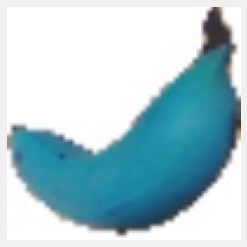

In [25]:
img = cv2.imread("0_100.jpg")
plt.imshow(img)
plt.axis('off')
plt.show()

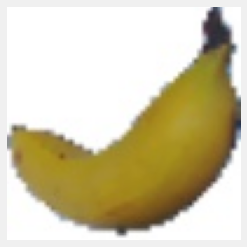

In [26]:
#import matplotlib.pyplot as plt
#import cv2
# Image originale
#img = cv2.imread("1_100.jpg")# this is read in BGR format
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)# this converts it into RGB
plt.imshow(rgb_img)
plt.axis('off')
plt.show()

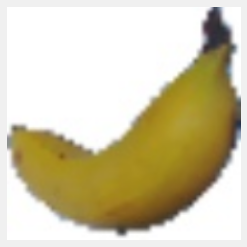

In [27]:
# Resizing
resizing = cv2.resize(rgb_img, (224, 224))
plt.imshow(resizing)
plt.axis('off')
plt.show()

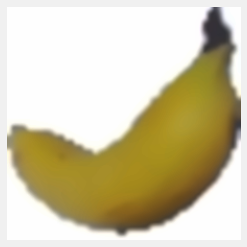

In [28]:
# Réduction de bruits
f_denoising = cv2.fastNlMeansDenoisingColored(resizing,None,10,10,7,21)
plt.imshow(f_denoising)
plt.axis('off')
plt.show()

## Principal Components Analysis (PCA)

### Preprocessing
- Mise à l'échelle des entrées

In [29]:
standardizer = StandardScaler(withMean=True, withStd=True,
                              inputCol='features',
                              outputCol='feats_scaled')
std = standardizer.fit(features_df)
features_df_scaled = std.transform(features_df)

In [30]:
features_df_scaled.printSchema()
features_df_scaled.show(10) 

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- feats_scaled: vector (nullable = true)

+--------------------+-----------+--------------------+--------------------+
|                path|      label|            features|        feats_scaled|
+--------------------+-----------+--------------------+--------------------+
|s3a://p8-fruits-s...|cauliflower|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,-0.1...|
|s3a://p8-fruits-s...|cauliflower|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,-0.1...|
|s3a://p8-fruits-s...|cauliflower|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,-0.1...|
|s3a://p8-fruits-s...|cauliflower|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,-0.1...|
|s3a://p8-fruits-s...|cauliflower|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,-0.1...|
|s3a://p8-fruits-s...|cauliflower|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,-0.1...|
|s3a://p8-fruits-s...|cauliflower|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,-0.1...|
|s3a://p8-fruits-s...|cauliflower|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0

### PCA fit transform

In [41]:
pca = PCA(k=6, inputCol="feats_scaled", outputCol="pca")
modelpca = pca.fit(features_df_scaled)
transformed = modelpca.transform(features_df_scaled)

In [42]:
transformed.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- feats_scaled: vector (nullable = true)
 |-- pca: vector (nullable = true)



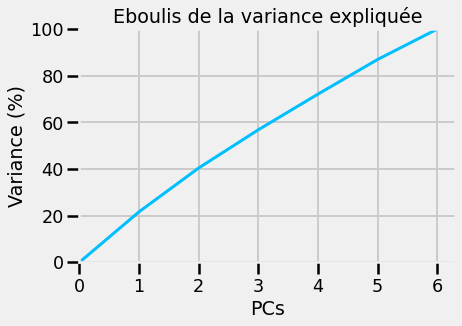

In [43]:
var = modelpca.explainedVariance.cumsum()
sns.set_context(context='poster', font_scale=0.8)
sns.lineplot(x=[i for i in range(7)], y=np.insert(var,0,0)*100, color='deepskyblue')
plt.xlabel('PCs')
plt.ylabel('Variance (%)')
plt.ylim(0,100)
plt.xlim(left=0)
plt.title("Eboulis de la variance expliquée")
plt.show()

In [44]:
transformed_final = transformed.select('path', 'label', 'pca')
transformed_pandas = transformed_final.toPandas()

In [45]:
transformed_pandas

,path,label,pca
0,s3a://p8-fruits-s3/input_images/cauliflower/r_...,cauliflower,"[-30.41435512439122, 203.2123984341592, 47.949..."
1,s3a://p8-fruits-s3/input_images/cauliflower/r_...,cauliflower,"[-22.931407273182447, 175.16075890231403, 55.0..."
2,s3a://p8-fruits-s3/input_images/cauliflower/r_...,cauliflower,"[11.11482455668715, 93.8151843463462, 30.05470..."
3,s3a://p8-fruits-s3/input_images/cauliflower/3_...,cauliflower,"[3.8623367712565377, 93.46342638466042, 18.060..."
4,s3a://p8-fruits-s3/input_images/cauliflower/r2...,cauliflower,"[22.36811710346734, 93.13710143828523, 30.2053..."
5,s3a://p8-fruits-s3/input_images/cauliflower/r2...,cauliflower,"[-5.137530082056506, 98.96288003829704, 17.220..."
6,s3a://p8-fruits-s3/input_images/cauliflower/11...,cauliflower,"[-11.845068913497244, 148.09960319568373, 22.2..."
7,s3a://p8-fruits-s3/input_images/cauliflower/12...,cauliflower,"[-12.535835794555966, 145.33106017388045, 22.7..."
8,s3a://p8-fruits-s3/input_images/cauliflower/r2...,cauliflower,"[-16.27935407805485, 90.04609107559911, 22.792..."
9,s3a://p8-fruits-s3/input_images/cauliflower/87...,cauliflower,"[-16.99176103066065, 145.9879459013928, 19.024..."


In [48]:
transformed_final.write.parquet('s3a://p8-fruits-s3/PCA_output.parquet')

In [49]:
# Transformation en dataframe pandas avec séparation des features dans une colonne dédiée

dfspark = spark.read.parquet("s3a://p8-fruits-s3/PCA_output.parquet")
df_p = dfspark.toPandas()
df_p.sample(3)

,path,label,pca
10,s3a://p8-fruits-s3/input_images/lemon/carambul...,lemon,"[-66.10038630288109, 40.9820295778406, -36.197..."
8,s3a://p8-fruits-s3/input_images/cauliflower/r2...,cauliflower,"[-16.27935407805485, 90.04609107559911, 22.792..."
21,s3a://p8-fruits-s3/input_images/Apple-Golden-3...,Apple-Golden-3,"[51.9034737395344, -21.178003202064478, 8.9577..."


In [50]:
# Mise en place d'un Dataframe avec pour chaque fruit une séparation en colonne de chaque feature identifié

df_final = pd.DataFrame(np.zeros((df_p.shape[0], 5)))
for i in range(5):
    df_final.loc[:,i] = df_p["pca"].apply(lambda x : x[i])

df_final_pca = pd.concat([df_p['label'], df_final], axis=1)

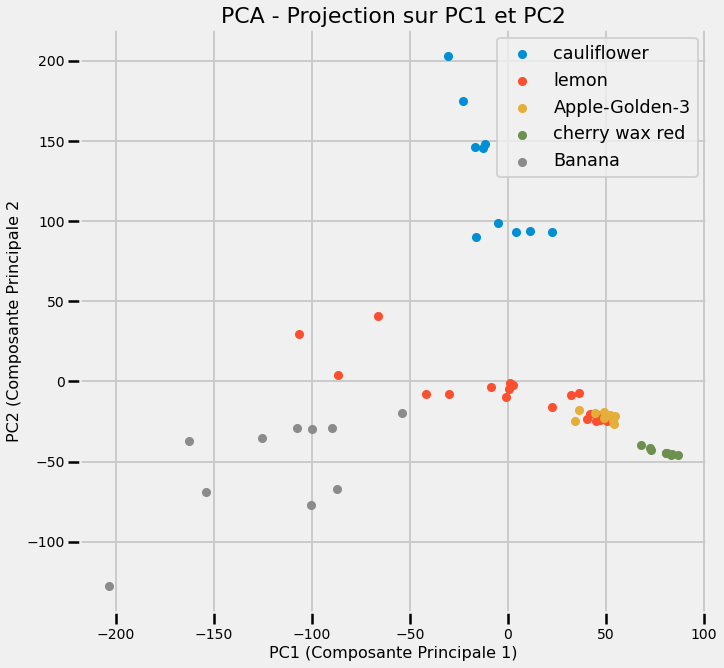

In [51]:
# Visualisation des différents fruits par projection sur les 2 axes principaux d'inertie

plt.figure(figsize=(10,10))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('PC1 (Composante Principale 1)',fontsize=16)
plt.ylabel('PC2 (Composante Principale 2',fontsize=16)

for fruit in df_final_pca.label.unique():
    dfred = df_final_pca[df_final_pca.label==fruit]
    plt.scatter(dfred[0], dfred[1], label=fruit, s=50)

plt.title("PCA - Projection sur PC1 et PC2",fontsize=22)

plt.legend()    
plt.show()

In [ ]:
#pip install s3fs

In [52]:
transformed_pandas.to_csv('s3://p8-fruits-s3/PCA_output.csv', index=False)